In [1]:
# Nescessary imports

%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # supress tensorflow warnings


# import libraries
import sys
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import rotate

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

# set random seed
random.seed(42)

%load_ext autoreload

In [2]:
%autoreload 2
from classes.data_wraper import Dataset

In [3]:
# mount google drive if using google colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
if 'google.colab' in sys.modules:
    root_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Colab Notebooks')
else:
    root_dir = os.getcwd()

if 'google.colab' in sys.modules:
    data_dir = os.path.join(root_dir, 'data')
else:
    data_dir = os.path.join(root_dir, 'data')

In [5]:
paths = {
    'FOVfiting2' : os.path.join(data_dir, 'mapsCeline_FOVfitting_2_pol-60.mat'),
    '3quadrants2' : os.path.join(data_dir, 'mapsCeline_3quadrants_2_pol-60.mat'),
    'FOVfiting3' : os.path.join(data_dir, 'mapsCeline_FOVfitting_3_pol-60.mat'),
    '3quadrants3' : os.path.join(data_dir, 'mapsCeline_3quadrants_3_pol-60.mat'),
    'FOVfiting4' : os.path.join(data_dir, 'mapsCeline_FOVfitting_4_pol-60.mat'),
    '3quadrants4' : os.path.join(data_dir, 'mapsCeline_3quadrants_4_pol-60.mat'),
    'FOVfiting5' : os.path.join(data_dir, 'mapsCeline_FOVfitting_5_pol-60.mat'),
    '3quadrants5' : os.path.join(data_dir, 'mapsCeline_3quadrants_5_pol-60.mat'),
    'FOVfiting6' : os.path.join(data_dir, 'mapsCeline_FOVfitting_6_pol-60.mat'),
    '3quadrants6' : os.path.join(data_dir, 'mapsCeline_3quadrants_6_pol-60.mat'),   
    'FOVfiting9' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9_pol-60.mat'),
    '3quadrants9' : os.path.join(data_dir, 'mapsCeline_3quadrants_9_pol-60.mat'),
    'FOVfiting9a' : os.path.join(data_dir, 'mapsCeline_FOVfitting_9a_polNP.mat'),
    '3quadrants9a' : os.path.join(data_dir, 'mapsCeline_3quadrants_9a_polNP.mat')
}

In [6]:
calibration_maps = [paths['FOVfiting2'], paths['FOVfiting3'], paths['FOVfiting4'], paths['FOVfiting5'], paths['FOVfiting6'], paths['FOVfiting9'], paths['3quadrants2'], paths['3quadrants3']]
#calibration_maps = [paths['FOVfiting2']]
#calibration_maps = [map for map in paths.values()]
dataset = Dataset(calibration_maps)

Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_2_pol-60.mat
New lenght: 297
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_3_pol-60.mat
New lenght: 594
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_4_pol-60.mat
New lenght: 891
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_5_pol-60.mat
New lenght: 1188
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_6_pol-60.mat
New lenght: 1485
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_FOVfitting_9_pol-60.mat
New lenght: 1782
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_3quadrants_2_pol-60.mat
New lenght: 2256
Added data from /content/drive/MyDrive/Colab Notebooks/data/mapsCeline_3quadrants_3_pol-60.mat
New lenght: 2730


In [7]:
dataset.preprocess_data()
dataset.crop_data(128)

In [8]:
X = np.stack((dataset.map1_list, dataset.map2_list, dataset.map3_list), axis=-1)
y = dataset.combined_list
azimut = dataset.azimut_list

In [9]:
print(np.min(X), np.max(X))
print(np.min(y), np.max(y))

0.0 1.0
0.1735880792373122 1.0


In [10]:
X_train, X_test, y_train, y_test, azimut_train, azimut_test = train_test_split(X, y, azimut, test_size=0.2, random_state=42)

In [11]:
%autoreload 2
from classes.UNet import UNet
from classes.Experiment import Experiment
from classes.utils import plot_map, plot_radial_profile

In [36]:
# Experiment
model = "UNet"
name = "MSE"

learning_rate = 0.001
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#loss = tf.keras.losses.MeanAbsoluteError()
# add L2 regularization to the loss function
loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
input_size = (X.shape[1], X.shape[2], 3)
output_size = (y.shape[1], y.shape[2], 1)
filters = [64,128,256]
dropout = 0.3

batch_size = 1
epochs = 10

if 'google.colab' in sys.modules:
    csv_path = os.path.join(root_dir, 'results', model + '.csv')
else:
    csv_path = os.path.join(root_dir, 'results', model + '.csv')

In [37]:
experiment = Experiment(model, name, optimiser, learning_rate, loss, input_size, output_size, filters, dropout, epochs, batch_size, csv_path)

In [38]:
experiment.make(X_train, y_train, X_test, y_test)

Epoch 1/10
1965/1965 [==============================] - 18s 7ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 2/10
1965/1965 [==============================] - 14s 7ms/step - loss: 6.5003e-04 - val_loss: 3.1356e-04
Epoch 3/10
1965/1965 [==============================] - 14s 7ms/step - loss: 5.3457e-04 - val_loss: 3.2518e-04
Epoch 4/10
1965/1965 [==============================] - 14s 7ms/step - loss: 3.9920e-04 - val_loss: 2.3446e-04
Epoch 5/10
1965/1965 [==============================] - 14s 7ms/step - loss: 3.9172e-04 - val_loss: 1.8881e-04
Epoch 6/10
1965/1965 [==============================] - 14s 7ms/step - loss: 2.9585e-04 - val_loss: 1.4203e-04
Epoch 7/10
1965/1965 [==============================] - 14s 7ms/step - loss: 2.2037e-04 - val_loss: 1.7975e-04
Epoch 8/10
1965/1965 [==============================] - 14s 7ms/step - loss: 2.1156e-04 - val_loss: 1.5666e-04
Epoch 9/10
1965/1965 [==============================] - 14s 7ms/step - loss: 1.7216e-04 - val_loss: 1.3752e-04
Epoch 10/

In [ ]:
experiment.save_experiment_csv()

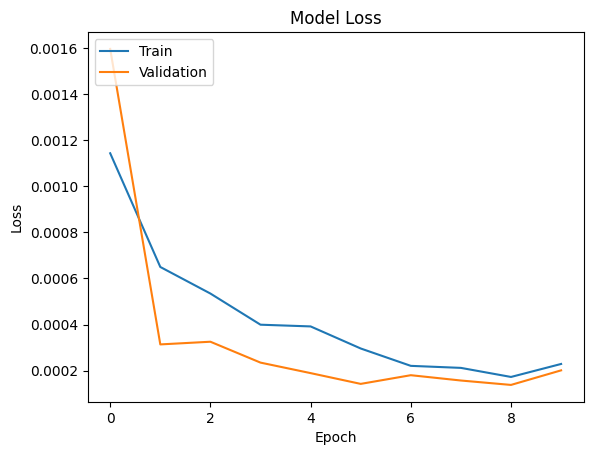

U-shaped graph saved at: unet_1.png


In [40]:
unet = experiment.get_model()

unet.plot_loss()

unet.summary(graph=True, graph_name="unet_1")

In [73]:
df = pd.read_csv(csv_path)
#df.head(len(df))
#df.describe()
df.iloc[-1]

Experiment number                            22
Name                                        MAE
Date                 2023-06-07 07:53:35.924072
Optimizer                                  Adam
Learning rate                             0.001
Loss                          MeanAbsoluteError
Input shape                       (128, 128, 3)
Output shape                      (128, 128, 1)
Filters                          [64, 128, 256]
Dropout                                     0.4
Epochs                                       10
Batch size                                    1
Test SSIM                              0.972445
Test PSNR                             38.661114
Test MSE                               0.000136
Name: 21, dtype: object

In [42]:
if 'google.colab' in sys.modules:
    model_path = os.path.join(root_dir, model + '_mse')
else:
    model_path = os.path.join(root_dir, model + '_mse')
unet.save_model(model_path)

In [43]:
unet = None
unet = UNet(model_path=model_path)

Loaded model from /content/drive/MyDrive/Colab Notebooks/UNet_mse


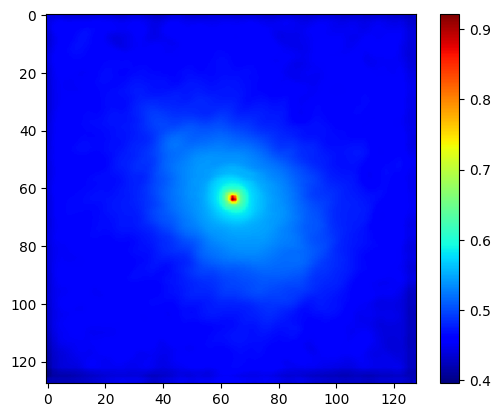

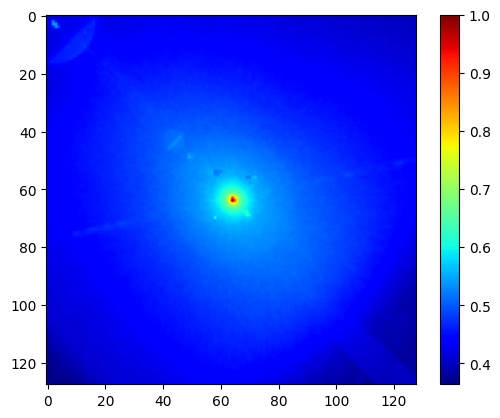

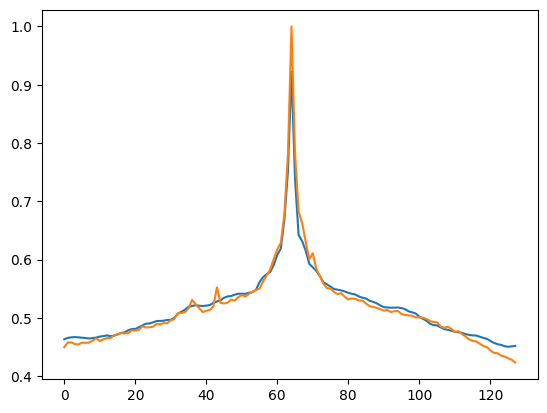

In [45]:
ind = random.randint(0, X_test.shape[0]-1)
pred = unet.predict(X_test[ind:ind+1])
plot_map(pred[0,:,:,0])
plot_map(y_test[ind])
plot_radial_profile([pred[0,:,:,0], y_test[ind]], azimut_test[ind])